<a href="https://colab.research.google.com/github/alphapum/Dataset_OCR_kaggle/blob/master/PP_Building_Thai_TTS_ed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-0db52d34-3541-ea31-1310-700cbabe5ac9)


## Getting NeMo-toolkit

In [1]:
# install from source
!git clone https://github.com/NVIDIA/NeMo
!cd NeMo/requirements


Cloning into 'NeMo'...
remote: Enumerating objects: 98026, done.
remote: Counting objects: 100% (1787/1787), done.
remote: Compressing objects: 100% (1284/1284), done.
remote: Total 98026 (delta 552), reused 1672 (delta 500), pack-reused 96239
Receiving objects: 100% (98026/98026), 212.94 MiB | 33.36 MiB/s, done.
Resolving deltas: 100% (70338/70338), done.


## Modify Parser for Thai phoneme
```
Phoneme format : w-a-n^-0|*n-ii-z^-3|*r-@@-ng^-0|*pr-a-z^-1|th-aa-z^-0|n-aa-z^-0|th-i-z^-3|b-@@-z^-0|d-ii-z^-0|*s-a-z^-1|h-a-z^-1|r-a-t^-3|th-a-z^-1|k-a-m^-0|m-aa-z^-0|l-aa-z^-0|*h-xx-z^-0|r-i-t^-3|*m-aa-z^-0|*th-v-ng^-4|*s-i-ng^-4|kh-a-z^-3|p-oo-z^-0|*
```
Add Thai phoneme parser into NeMo/nemo/collections/common/parts/preprocessing/parsers.py

```python
class THCharParser(CharParser):
    """Incorporates english-specific parsing logic."""

    PUNCTUATION_TO_REPLACE = frozendict.frozendict({'+': 'plus', '&': 'and', '%': 'percent'})

    def __init__(self, abbreviation_version=None, make_table=True, *args, **kwargs):
        """Creates english-specific mapping char parser.

        This class overrides normalizing implementation.

        Args:
            *args: Positional args to pass to `CharParser` constructor.
            **kwargs: Key-value args to pass to `CharParser` constructor.
        """

        super().__init__(*args, **kwargs)

        self._table = None
        if make_table:
            self._table = self.__make_trans_table()
        self.abbreviation_version = abbreviation_version
        
        self.i = 0

    def __make_trans_table(self):
        punctuation = string.punctuation

        for char in self.PUNCTUATION_TO_REPLACE:
            punctuation = punctuation.replace(char, '')

        for label in self._labels:
            punctuation = punctuation.replace(label, '')

        table = str.maketrans(punctuation, ' ' * len(punctuation))

        return table

    def _normalize(self, text: str) -> Optional[str]:
        # noinspection PyBroadException
        try:
            text = cleaners.clean_text(
                string=text,
                table=self._table,
                punctuation_to_replace=self.PUNCTUATION_TO_REPLACE,
                abbreviation_version=self.abbreviation_version,
            )
        except Exception:
            return None

        return text
    
    def _tokenize(self, text: str) -> List[int]:
        tokens = []
        # Split by word for find special labels.
        for word_id, word in enumerate(text.split('|*')):
            if word =="":
                continue
                
            if word_id != 0:  # Not first word - so we insert space before.
                tokens.append(self._labels_map.get('|', self._unk_id))

            #if word in self._special_labels:
            #    tokens.append(self._labels_map[word])
            #    continue
            #print(word.split("-"))
            
            syls = word.split("|")
            phns = []
            for s in syls:
                if s =="sp2":
                    phns.append(s)
                else:
                    p = s.split("-")
                    phns.append(p[0])
                    phns.append(p[1]+p[-1])
                    
                    if p[2] !="z^":
                        phns.append(p[2])
            #print(phns)
            for char in phns: #split word to phonemes
                tokens.append(self._labels_map.get("_"+char, self._unk_id))
        
        #test verbose
        if self.i < 5:
            print(text)
            print(tokens)
            self.i+=1
        # If unk_id == blank_id, OOV tokens are removed.
        tokens = [token for token in tokens if token != self._blank_id]
        
        return tokens
    
NAME_TO_PARSER = frozendict.frozendict({'base': CharParser, 'en': ENCharParser,'th': THCharParser})
```

## Changing input from text to phoneme 
Modify manifest.py to use phoneme instead of text input (NeMo/nemo/collections/common/parts/preprocessing/manifest.py)

```python
def __parse_item(line: str, manifest_file: str) -> Dict[str, Any]:
    item = json.loads(line)

    # Audio file
    if 'audio_filename' in item:
        item['audio_file'] = item.pop('audio_filename')
    elif 'audio_filepath' in item:
        item['audio_file'] = item.pop('audio_filepath')
    else:
        raise ValueError(
            f"Manifest file {manifest_file} has invalid json line structure: {line} without proper audio file key."
        )
    item['audio_file'] = expanduser(item['audio_file'])

    # Duration.
    if 'duration' not in item:
        raise ValueError(
            f"Manifest file {manifest_file} has invalid json line structure: {line} without proper duration key."
        )

    # Text.
    if 'text' in item:
        pass
    elif 'text_filepath' in item:
        with open(item.pop('text_filepath'), 'r') as f:
            item['text'] = f.read().replace('\n', '')
    elif 'normalized_text' in item:
        item['text'] = item['normalized_text']
    
    #replace text with phoneme
    if 'raw_phoneme' in item:
        item['text'] = item['raw_phoneme']

    item = dict(
        audio_file=item['audio_file'],
        duration=item['duration'],
        text=item.get('text', ""),
        offset=item.get('offset', None),
        speaker=item.get('speaker', None),
        orig_sr=item.get('orig_sample_rate', None),
    )

    return item
```

## Install dependecies

In [2]:
!find . -name "requirement*" -type f -exec pip install -qq -r '{}' ';'

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 2.8 MB 59.4 MB/s 
     |████████████████████████████████| 90 kB 10.2 MB/s 
     |████████████████████████████████| 121 kB 64.6 MB/s 
     |████████████████████████████████| 100 kB 11.1 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 561 kB 51.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 527 kB 5.1 MB/s 
     |████████████████████████████████| 397 kB 54.2 MB/s 
     |████████████████████████████████| 3.5 MB 51.6 MB/s 
     |████████████████████████████████| 74 kB 3.7 MB/s 
     |████████████████████████████████| 145 kB 55.1 MB/s 
     |████████████████████████████████| 636 

In [3]:
## add NeMo's directory to pythonpath
import sys
sys.path.insert(0, "/content/NeMo")
import nemo

# Building Thai TTS using Tacotron2





## Prepare transcription files
/opt/Corpus/suthichai_yoon/sent_all.txt

```
****suthichai_10_1_4****
วันนี้รองประธานาธิบดีสหรัฐกัมมาลา แฮริส มาถึงสิงคโปร์
วันนี้รองประธานาธิบดีสหรัฐกัมมาลา แฮริส มาถึงสิงคโปร์

****suthichai_10_1_6****
เป็นจุดเริ่มต้นของการมาเยือนอาเซี่ยน 2 ประเทศ
เป็นจุดเริ่มต้นของการมาเยือนอาเซี่ยนสองประเทศ

****suthichai_10_1_10****
มีความหมายน่าสนใจมากครับ เพราะว่าเท่ากับว่าประธาธิบดีโจไบเดนนั้นส่งให้รองประธานาธิบดี
มีความหมายน่าสนใจมากครับ เพราะว่าเท่ากับว่าประธาธิบดีโจไบเดนนั้นส่งให้รองประธานาธิบดี
```

## Prepare phoneme transcription files
```
****suthichai_10_1_4****
วันนี้รองประธานาธิบดีสหรัฐกัมมาลา แฮริส มาถึงสิงคโปร์
วัน|นี้|รอง|ประธานาธิบดี|สหรัฐกัมมาลา|แฮริส|มา|ถึง|สิงคโปร์|
w-a-n^-0|*n-ii-z^-3|*r-@@-ng^-0|*pr-a-z^-1|th-aa-z^-0|n-aa-z^-0|th-i-z^-3|b-@@-z^-0|d-ii-z^-0|*s-a-z^-1|h-a-z^-1|r-a-t^-3|th-a-z^-1|k-a-m^-0|m-aa-z^-0|l-aa-z^-0|*h-xx-z^-0|r-i-t^-3|*m-aa-z^-0|*th-v-ng^-4|*s-i-ng^-4|kh-a-z^-3|p-oo-z^-0|*

****suthichai_10_1_6****
เป็นจุดเริ่มต้นของการมาเยือนอาเซี่ยนสองประเทศ
เป็น|จุด|เริ่มต้น|ของการ|มา|เยือน|อาเซี่ยน|สอง|ประเทศ|
p-e-n^-0|*c-u-t^-1|*r-qq-m^-2|t-o-n^-2|*kh-@@-ng^-4|k-aa-n^-0|*m-aa-z^-0|*j-vva-n^-0|*z-aa-z^-0|s-iia-n^-2|*s-@@-ng^-4|*pr-a-z^-1|th-ee-t^-2|*
```

## Automatic phoneme forced alignment
Installl Montreal Forced Aligner toolkit
https://github.com/MontrealCorpusTools/Montreal-Forced-Aligner


Create script file : /opt/forced_align_tool/job_scripts/run_align_yoon.sh

```bash
spk=ver3
set_name=suthichai
step=$1

trans_file="transcriptions/suthichai/suthichai_v3_script.txt"

./run_forced_alignment.sh ${set_name}_${spk} ${spk} $trans_file $step;
```

Getting word and phoneme durations
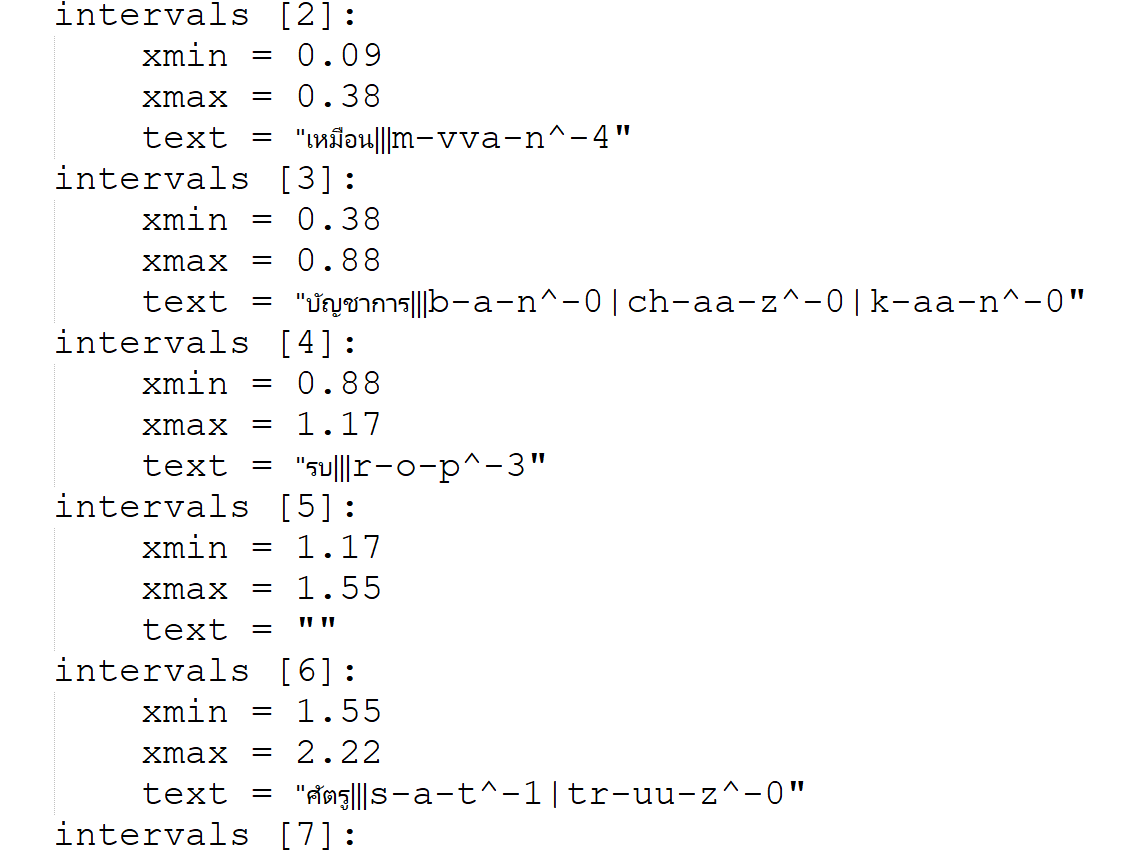

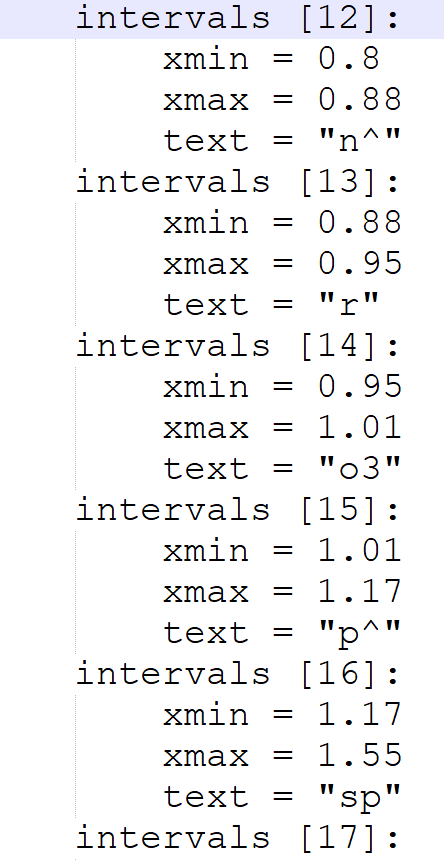

## Export data and json files
```bash
bash scripts/faspitch/extract_thai_kook.sh \
/opt/forced_align_tool/egs/suthichai_ver3/data/ver3 \
/opt/forced_align_tool/egs/suthichai_ver3/suthichai_ver3_mfa_data/forced_output_text/ver3 \
"dur|pitch|flist2" suttichai_ver3 14 00
```

The .json files should adhere to the format required by the `nemo.collections.asr.data.audio_to_text.AudioToCharDataset` class. For example, here is a sample .json file

```json
{"audio_filepath": "/opt/forced_align_tool/egs/tsync1_v2_val_kook/data/kook/wavs/tsync1_kook_1_171_57_4_2.wav", "duration": 2.910975, "text": "และ|สเปกโทรโฟโตมิเตอร์ |เป็นต้น|sp", "phoneme": "l|x3|s|a1|p|e3|k^|thr|oo0|f|oo0|t|oo0|m|i3|t|qq2|p|e0|n^|t|o2|n^|sp", "raw_phoneme": "l-x-z^-3|*s-a-z^-1|p-e-k^-3|thr-oo-z^-0|f-oo-z^-0|t-oo-z^-0|m-i-z^-3|t-qq-z^-2|*p-e-n^-0|t-o-n^-2|*sp", "word_dur": "16|149|74|12", "syl_cnt": "1|7|2|0", "speaker": 1, "language": 0}
{"audio_filepath": "/opt/forced_align_tool/egs/tsync1_v2_val_kook/data/kook/wavs/tsync1_kook_1_175_24_28.wav", "duration": 4.584898, "text": "sp|ซึ่ง|เป็น|เครื่อง|sp|แสดง|ว่า|มี|สนามแม่เหล็ก|sp|เปลี่ยนแปลง|sp", "phoneme": "sp|s|v2|ng^|p|e0|n^|khr|vva2|ng^|sp|s|a1|d|xx0|ng^|w|aa2|m|ii0|s|a1|n|aa4|m^|m|xx2|l|e1|k^|sp|pl|iia1|n^|pl|xx0|ng^|sp", "raw_phoneme": "sp|*s-v-ng^-2|*p-e-n^-0|*khr-vva-ng^-2|*sp|*s-a-z^-1|d-xx-ng^-0|*w-aa-z^-2|*m-ii-z^-0|*s-a-z^-1|n-aa-m^-4|m-xx-z^-2|l-e-k^-1|*sp|*pl-iia-n^-1|pl-xx-ng^-0|*sp", "word_dur": "4|33|22|53|5|53|18|22|84|7|85|9", "syl_cnt": "0|1|1|1|0|2|1|1|4|0|2|0", "speaker": 1, "language": 0}
...
```
Please note that the duration is in seconds.

## Modify config file
Modify the labels from English text to Thai phoneme: training_scripts/config/tacotron2.yaml

```yaml
name: &name Tacotron2
sample_rate: &sr 22050
# <PAD>, <BOS>, <EOS> will be added by the tacotron2.py script
labels: &labels ['|','~','<sp>','<asp>','<dsp>','_sp2',' ','-','!', "'", '(', ')', '.', ':', ';', '?',',','$', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','SIL','PAU','_b', '_bl', '_br', '_c', '_ch', '_d', '_dr', '_f', '_fl', '_fr', '_h', '_j', '_k', '_kh', '_khl', '_khr', '_khw', '_kl', '_kr', '_kw', '_l', '_m', '_n', '_ng', '_p', '_ph', '_phl', '_phr', '_pl', '_pr', '_r', '_s', '_sh', '_t', '_th', '_tha', '_thr', '_tl', '_tr', '_w', '_y', '_z', '_@0', '_@1', '_@2', '_@3', '_@4', '_@5', '_@6', '_@7', '_@@0', '_@@1', '_@@2', '_@@3', '_@@4', '_@@5', '_@@6', '_@@7', '_a0', '_a1', '_a2', '_a3', '_a4', '_a5', '_a6', '_a7', '_aa0', '_aa1', '_aa2', '_aa3', '_aa4', '_aa5', '_aa6', '_aa7', '_e0', '_e1', '_e2', '_e3', '_e4', '_e5', '_e6', '_e7', '_ee0', '_ee1', '_ee2', '_ee3', '_ee4', '_ee5', '_ee6', '_ee7', '_i0', '_i1', '_i2', '_i3', '_i4', '_i5', '_i6', '_i7', '_ia0', '_ia1', '_ia2', '_ia3', '_ia4', '_ii0', '_ii1', '_ii2', '_ii3', '_ii4', '_ii5', '_ii6', '_ii7', '_iia0', '_iia1', '_iia2', '_iia3', '_iia4', '_iia5', '_iia6', '_iia7', '_o0', '_o1', '_o2', '_o3', '_o4', '_o5', '_o6', '_o7', '_oo0', '_oo1', '_oo2', '_oo3', '_oo4', '_oo5', '_oo6', '_oo7', '_q0', '_q1', '_q2', '_q3', '_q4', '_q5', '_q6', '_q7', '_qq0', '_qq1', '_qq2', '_qq3', '_qq4', '_qq5', '_qq6', '_qq7', '_u0', '_u1', '_u2', '_u3', '_u4', '_u5', '_u6', '_u7', '_ua0', '_ua2', '_ua3', '_uu0', '_uu1', '_uu2', '_uu3', '_uu4', '_uu5', '_uu6', '_uu7', '_uua0', '_uua1', '_uua2', '_uua3', '_uua4', '_uua5', '_uua6', '_uua7', '_v0', '_v1', '_v2', '_v3', '_v4', '_v5', '_v6', '_v7', '_vv0', '_vv1', '_vv2', '_vv3', '_vv4', '_vv5', '_vv6', '_vv7', '_vva0', '_vva1', '_vva2', '_vva3', '_vva4', '_vva5', '_vva6', '_vva7', '_x0', '_x1', '_x2', '_x3', '_x4', '_x5', '_x7', '_xx0', '_xx1', '_xx2', '_xx3', '_xx4', '_xx5', '_xx6', '_xx7', '_c^', '_ch^', '_d^', '_f^', '_j^', '_jf^', '_js^', '_k^', '_ks^', '_l^', '_ls^', '_m^', '_n^', '_ng^', '_ns^', '_p^', '_s^', '_t^', '_ts^', '_w^','AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0', 'AO1', 'AO2', 'AW0', 'AW1', 'AW2', 'AY0', 'AY1', 'AY2', 'B', 'CH', 'D', 'DH', 'EH0', 'EH1', 'EH2', 'ER0', 'ER1', 'ER2', 'EY0', 'EY1', 'EY2', 'F', 'G', 'HH', 'IH0', 'IH1', 'IH2', 'IY0', 'IY1', 'IY2', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW0', 'OW1', 'OW2', 'OY0', 'OY1', 'OY2', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH0', 'UH1', 'UH2', 'UW0', 'UW1', 'UW2', 'V', 'W', 'Y', 'Z', 'ZH']

n_fft: &n_fft 1024
n_mels: &n_mels 80
fmax: &fmax null
n_stride: &n_window_stride 256
pad_value: &pad_value -11.52
train_dataset: ???
validation_datasets: ???
```


```


## Create script for training
create script for training 

NeMo/training_scripts/job_tacotron.sh

```bash
#!/bin/bash 

export CUDA_VISIBLE_DEVICES=0
export LC_ALL=C.UTF-8

python3 tacotron2.py sample_rate=22050 \
train_dataset=/opt/forced_align_tool/egs/tsync1_v2_val_kook/data/kook/kook_cnt_syl_train.json \
validation_datasets=/opt/forced_align_tool/egs/tsync1_v2_val_kook/data/kook/kook_cnt_syl_val.json \
trainer.max_epochs=5000 \
trainer.check_val_every_n_epoch=5 \
model.train_ds.dataloader_params.batch_size=25 \
exp_manager.name=Tacotron2_Test
```

# Inference Thai TTS using trained checkpoint

This notebook aims to show how to build Thai TTS using NeMo. 


In [4]:
# Finally, we'll get the trained NeMo model.
# https://drive.google.com/file/d/1x8jERWDcpfwaVq0nWTluwIR7conxvUGj/view?usp=sharing
# https://drive.google.com/file/d/1DoEuDagxR0s2br4C9appZV1tGhDb6oe5/view?usp=sharing
# https://drive.google.com/file/d/1rKMfRJN0atotDclTbymNd4A-IExpq7Oa/view?usp=sharing
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1rKMfRJN0atotDclTbymNd4A-IExpq7Oa


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.3.1-py3-none-any.whl size=14493 sha256=a806a3306ea134778e05e72fe14e1cdf8c41b325b0f0220ac42749404a85052f
  Stored in directory: /tmp/pip-ephem-wheel-cache-22qd9z86/wheels/39/13/56/88209f07bace2c1af0614ee3326de4a00aad74afb0f4be921d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.1
    Uninstalling gdown-4.2.1:
      Successfully uninstalled gdown-4.2.1
Downloading...
From: https://drive.google.com/uc?id=1rKMfRJN0atotDclTbymNd4A-IExpq7Oa
To: /content/Tacotron2_noon_fp16_pretrainedKook3159.ckpt
100% 340M/340M [00:01<00:00, 190MB/s]


In [5]:
from nemo.collections.tts.models import Tacotron2Model

model_loc="/content/Tacotron2_noon_fp16_pretrainedKook3159.ckpt"
model =  Tacotron2Model.load_from_checkpoint(model_loc).cuda().eval()

[NeMo W 2022-02-21 09:56:08 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-02-21 09:56:13 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_filepath: /tarafs/scratch/proj0117-vistts/Pytorch_Train/data/noon_trim/trim_wav_tsync2_noon_train.json
      max_duration: 13
      min_duration: 

[NeMo I 2022-02-21 09:56:13 features:255] PADDING: 16
[NeMo I 2022-02-21 09:56:13 features:272] STFT using torch


In [9]:
from nemo.collections.tts.models.base import Vocoder
vocoder_name="tts_hifigan"
vocoder = Vocoder.from_pretrained(vocoder_name).eval().cuda()

[NeMo I 2022-02-21 09:58:46 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /root/.cache/torch/NeMo/NeMo_1.7.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-02-21 09:58:56 common:704] Instantiating model from pre-trained checkpoint


[NeMo W 2022-02-21 09:59:00 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-02-21 09:59:00 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-02-21 09:59:00 features:255] PADDING: 0
[NeMo I 2022-02-21 09:59:00 features:272] STFT using torch


[NeMo W 2022-02-21 09:59:00 features:233] Using torch_stft is deprecated and will be removed in 1.1.0. Please set stft_conv and stft_exact_pad to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-02-21 09:59:00 features:255] PADDING: 0
[NeMo I 2022-02-21 09:59:00 features:272] STFT using torch
[NeMo I 2022-02-21 09:59:01 save_restore_connector:157] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.7.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [10]:
# Load the Tacotron2Model
from nemo.collections.tts.models import Tacotron2Model
from nemo.collections.tts.models.base import SpectrogramGenerator

# Tacotron2 is a SpectrogramGenerator
assert isinstance(model, SpectrogramGenerator)

# SpectrogramGenerators in NeMo have two helper functions:
#   1. parse(str_input: str, **kwargs) which takes an English string and produces a token tensor
#   2. generate_spectrogram(tokens: 'torch.tensor', **kwargs) which takes the token tensor and generates a spectrogram
# Let's try it out
# tokens = model.parse(str_input = "s-a-z^-1|w-a-t^-1|d-ii-z^-0|*kh-a-z^-2|*th-o-t^-3|s-@@-p^-1|*k-aa-n^-0|*s-a-ng^-4|*khr-@-z^-3|*s-iia-ng^-4")
tokens = model.parse(str_input = "w-a-n^-0|*th-ii-z^-2|*k-aa-w^-2|*m-a-z^-3|k-a-z^-1|r-aa-z^-0|kh-o-m^-0|*p-ii-z^-0|*s-@@-ng^-4|*s-uu-n^-4|*s-uu-n^-4|*k-aa-w^-2|*sp2|*b-i-t^-1|*kh-@@-j^-0|*d-aa-j^-2|*p-qq-t^-1|*z-oo-z^-3|p-ee-n^-2|*s-@@-t^-3|*h-a-j^-2|*kh-o-n^-0|*th-uua-z^-2|p-a-j^-0|*sp2|*d-aa-j^-2|*kh-a-w^-2|*th-v-ng^-4")
print(tokens)


w-a-n^-0|*th-ii-z^-2|*k-aa-w^-2|*m-a-z^-3|k-a-z^-1|r-aa-z^-0|kh-o-m^-0|*p-ii-z^-0|*s-@@-ng^-4|*s-uu-n^-4|*s-uu-n^-4|*k-aa-w^-2|*sp2|*b-i-t^-1|*kh-@@-j^-0|*d-aa-j^-2|*p-qq-t^-1|*z-oo-z^-3|p-ee-n^-2|*s-@@-t^-3|*h-a-j^-2|*kh-o-n^-0|*th-uua-z^-2|p-a-j^-0|*sp2|*d-aa-j^-2|*kh-a-w^-2|*th-v-ng^-4
[89, 108, 279, 0, 84, 155, 0, 62, 118, 286, 0, 71, 111, 62, 109, 80, 116, 63, 169, 278, 0, 74, 153, 0, 81, 104, 280, 0, 81, 216, 279, 0, 81, 216, 279, 0, 62, 118, 286, 0, 7, 0, 50, 141, 284, 0, 63, 100, 271, 0, 55, 118, 271, 0, 74, 194, 284, 0, 91, 180, 74, 134, 279, 0, 81, 103, 284, 0, 60, 110, 271, 0, 63, 169, 279, 0, 84, 222, 74, 108, 271, 0, 7, 0, 55, 118, 271, 0, 63, 110, 286, 0, 84, 232, 280]
tensor([[356,  89, 108, 279,   0,  84, 155,   0,  62, 118, 286,   0,  71, 111,
          62, 109,  80, 116,  63, 169, 278,   0,  74, 153,   0,  81, 104, 280,
           0,  81, 216, 279,   0,  81, 216, 279,   0,  62, 118, 286,   0,   7,
           0,  50, 141, 284,   0,  63, 100, 271,   0,  55, 118, 271,   

In [11]:
spectrogram = model.generate_spectrogram(tokens=tokens)


In [12]:
audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)


In [13]:
%matplotlib inline
import torch
import IPython.display as ipd

def show_audio(audio):
  with torch.no_grad():
    if isinstance(audio, torch.Tensor):
      audio = audio.to('cpu').numpy()
      #print("show audio")
      ipd.display(ipd.Audio(audio, rate=22050))


In [14]:
show_audio(audio)